# Method: RC 
# Dataset: KS Equation, L = 60
# Purpose: Prediction

# 1. Set-up

In [1]:
# GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# Package
import sys
sys.path.append("../..")

In [2]:
from create_data import load_data
from utils import * # Number of testing samples
import numpy as np
import matplotlib.pyplot as plt
from time import time
from scipy import sparse

import jax
import jax.numpy as jnp
from jax import value_and_grad
from jax.numpy import tanh
from jax.example_libraries import optimizers

In [3]:
SEED = 42

In [4]:
train, test = load_data("KS, L = 100", "../../data/ks60", 0.5)

In [5]:
print(f"Train size: {train.data.shape}")
print(f"Test size: {test.data.shape}")

Train size: (90000, 240)
Test size: (90000, 240)


**Create test set**

In [6]:
L_forecast_test = 400   # steps to forecast forward (when testing)

In [7]:
np.random.seed(1)

data_test = test.data

T_test, data_dim = data_test.shape
possible_idx = T_test - (L_forecast_test + 1) # minus number of steps forward, and the warm-up period
T_indices = np.random.randint(0, possible_idx, size = NUM_TEST)

t_past_batch = np.repeat(T_indices[:, None], WARM_UP_TEST, axis = 1).astype(int) # 200 warmup 
t_pred_batch = (T_indices[:, None] + np.arange(1, 1 + L_forecast_test)[None, :].astype(int))

X_test = data_test[t_past_batch]
y_test = data_test[t_pred_batch]

In [8]:
print(f"Test input size: {X_test.shape}")  # Number of test points x input length x dim
print(f"Test output size: {y_test.shape}") # Number of test points x horizon x dim

Test input size: (100, 2000, 240)
Test output size: (100, 400, 240)


# 2. RC Implementation

In [9]:
def get_parameters(nn_size, connectivity, spec_radius, lambd, 
                   seed, batch_size, num_epoch, lr_schedule = [1e-4], 
                   early_stopping = EARLY_STOPPING):
    """
    Returns trained parameters (beta, intercept) and hidden layer values
    """
    def initialize_coef():
        """
        Initializes W_in and W. 
        W_in size = nn_size x data_dim
        W size = nn_size x nn_size
        """
        start = time()

        # Generate input -> hidden unit weights
        W_in = 2 * (np.random.rand(nn_size, data_dim) - 0.5) 
        W_in = W_in / (4 * np.sqrt(data_dim))

        # Generate hidden -> hidden unit weights
        # Considers connectivity to make the matrix sparse
        start_mat = time()
        rows = np.concatenate([np.full(connectivity, i) for i in range(nn_size)])
        cols = np.concatenate([np.random.choice(range(nn_size), size = connectivity, replace = False) for _ in range(nn_size)])
        vals = np.random.uniform(low = -omega, high = omega, size = (nn_size * connectivity))
        W = sparse.csr_matrix((vals, (rows, cols)), shape = (nn_size, nn_size))
        end_mat = time()
        print(f"W generated. Time taken: {end_mat - start_mat:.2f}s")

        # Calculate eigenvalues for scaling of matrix
        print("Calculating eigenvalue")
        e_start = time()
        eigenvals = sparse.linalg.eigs(W, which = "LM", return_eigenvectors = False, k = 1)
        max_eigen = np.abs(eigenvals)
        e_end = time()
        print(f"Eigenvalue calculated. Time taken: {e_end - e_start:.2f}s")

        # Scale matrix by spectral radius
        W = W / max_eigen * spec_radius # scale the matrix W by its spectral radius
        W = sparse.csr_matrix(W)
        
        end = time()
        print(f"W and W_in generated. Time taken: {end-start:.2f}s")
        print()
        
        return W_in, W
    
    def generate_hidden_states(W_in, W):
        """ 
        Generate hidden states (z) values
        hidden_states size = data_size x nn_size 
        """
        start = time()
        
        print("Generating z values...")
        indiv_z = np.zeros(shape = nn_size)
        hidden_states = np.zeros((train_size, nn_size))
        
        for t in range(train_size):  
            indiv_z = (1 - alpha) * indiv_z + \
                alpha * np.tanh(W_in @ x[t] + W @ indiv_z)
            hidden_states[t, :] = indiv_z
        end = time()
        print(f"z values generated. Time taken: {end-start:.2f}s")
        
        return hidden_states
    
    def mse(y, y_pred):
        return jnp.mean((y_pred - y)**2)
    
    @jax.jit
    def mse_loss(params, x, y):
        """
        returns mean squared error
        """
        beta, intercept = params
        pred = x @ beta + intercept
        return mse(pred, y) + np.mean(beta**2) * lambd / 2 + np.mean(intercept**2) * lambd / 2
    
    def validation_loss(params, x_val, y_val):
        beta, intercept = params
        num_data_test, trans, data_dim = x_val.shape # testing ex, # steps used (transient), dim of data

        def prediction(inp):
            """
            Returns the mean of one of the testing input

            mean will be a length_to_test x data_dim vector
            """
            z = np.zeros((nn_size // 2, ))
            for i in range(trans):
                z = (1 - alpha) * z + alpha * np.tanh(W_in @ inp[i] + W @ z)

            mus = []
            stddevs = []

            x = beta.T @ np.concatenate([z, z**2]) + intercept # output / input_of_next | size = dim_data
            mus.append(x)

            for _ in range(L_forecast_test - 1):
                z = (1 - alpha) * z + alpha * np.tanh(W_in @ x + W @ z)
                x = beta.T @ np.concatenate([z, z**2]) + intercept # output / input_of_next
                mus.append(x)

            return mus

        mean_list = []
        sd_list = []

        for i in range(num_data_test):
            pred = prediction(x_val[i])
            mean_list.append(pred)

        return mse(mean_list, y_val)

    def training(x, y):
        """ 
        Trains regression of y~x using SGD. 
        Returns parameters (beta, intercept) where 
        beta, intercept -> weights to determine the mean
        
        beta size = nn_size x data_dim
        intercept = data_dim (will be added for each training data)
        
        should predict a mu with train_size x data_dim (\mu per dimension per datapoint)
        and a sigma with train_size x 1 (single \sigma for all dimensions per datapoint)
        """
        
        @jax.jit
        def step(opt_state, x, y):
            params = get_params(opt_state)
            value, g = value_and_grad(mse_loss)(params, x, y)
            opt_state = opt_update(0, g, opt_state)
            return get_params(opt_state), opt_state, value

        start = time()
        
        # Plot loss
        loss_train_traj = []
        loss_train_all_traj = []
        
        # Init parameters
        beta = np.random.normal(0, 1 / np.sqrt(nn_size), size = (nn_size, data_dim))
        intercept = np.random.normal(0, 1 / np.sqrt(nn_size * 2), size = (data_dim, ))
        
        t_size = int(1. * train_size)
        
        overall_best_mse = 9999999
        
        for i, lr in enumerate(lr_schedule):
            opt_init, opt_update, get_params = optimizers.adam(step_size = lr) 
            opt_state = opt_init([beta, intercept])
            
            # For early stopping
            best_state = opt_state
            counter = 0 
            best_val_loss = 9999999
            
            for epoch in range(num_epoch[i]):
                e_start = time()
                
                T_indices = np.arange(train_size)
                np.random.shuffle(T_indices)

                loss_epoch_train = []
                for k in range(t_size // batch_size + 1):
                    t_start = T_indices[np.arange(k * batch_size, (k+1) * batch_size).astype(int) % len(T_indices)]
                    x_batch = x[t_start]
                    y_batch = y[t_start]

                    params, opt_state, l = step(opt_state, x_batch, y_batch)
                    loss_epoch_train.append(l)
                
                
                loss_train_all_traj += loss_epoch_train
                mse_train = np.mean(loss_epoch_train)
                loss_train_traj.append(mse_train)
                
                e_end = time()
                
                if mse_train < best_val_loss:
                    best_val_loss = mse_train
                    counter = 0
                    best_state = opt_state
                else:
                    counter += 1
                    
                if (epoch + 1) % 10 == 0 or (counter == 0 and epoch > 49):
                    print(f"Epoch {epoch + 1}: Train time = {e_end - e_start:.2f} | Train Loss = {mse_train:.7f}", end = " ")
                    print()
                if counter == early_stopping:
                    print(f"EARLY STOPPING. Epoch {epoch + 1}: Train loss = {mse_train:.7f}")
                    break
            
            print(f"Best Training MSE: {best_val_loss:.7f}") 
            
            if best_val_loss < overall_best_mse:
                print("IMPROVED VALIDATION MSE")
                overall_best_mse = best_val_loss
                overall_best_state = best_state
            
            beta, intercept = get_params(overall_best_state)
            print()
        
        end = time()
        print(f"Total time: {end - start:.2f}")
        
        return get_params(overall_best_state) # beta, intercept
    
    start = time()
   
    x, y = train.data[:-1], train.data[1:]
    copy_x, copy_y = x, y 
    train_size, data_dim = x.data.shape
       
    np.random.seed(seed)
    W_in, W = initialize_coef()
    z = generate_hidden_states(W_in, W)

    # Want to regression Y ~ X ==> Y ~ [z, z**2]
    final_y = y[transient:]
    final_z = z[transient:]
    print("Concatenating z with z**2", end = " "); concat_start = time()
    final_z = np.concatenate([final_z, final_z**2], axis = 1) # shape: train_size x (nn_size*2)
    concat_end = time()
    print(f"Contenation complete. Time taken: {concat_end-concat_start:.2f}s", end = "\n\n")
    
    train_size, nn_size = final_z.shape
    
    params = training(final_z, final_y)
    end = time()
    print(f"Complete. Time taken: {end - start:.2f}s")
    
    return params, (final_z, W_in, W)

In [10]:
def get_test_pred(data_test, nn_size, params, W_in, W):   
    beta, intercept = params
    num_data_test, trans, data_dim = data_test.shape # testing ex, # steps used (transient), dim of data
    
    def prediction(inp):
        """
        Returns the mean of one of the testing input
        
        mean will be a length_to_test x data_dim vector
        """
        
        z = np.zeros((nn_size, ))
        for i in range(trans):
            z = (1 - alpha) * z + alpha * np.tanh(W_in @ inp[i] + W @ z)
        
        mus = []
        stddevs = []
        
        x = beta.T @ np.concatenate([z, z**2]) + intercept # output / input_of_next | size = dim_data
        mus.append(x)
        
        for _ in range(L_forecast_test - 1):
            z = (1 - alpha) * z + alpha * np.tanh(W_in @ x + W @ z)
            x = beta.T @ np.concatenate([z, z**2]) + intercept # output / input_of_next
            mus.append(x)
        
        return mus
    
    start = time()
    
    mean_list = []
    sd_list = []
    
    for i in range(num_data_test):
        pred = prediction(data_test[i])
        mean_list.append(pred)

        if (i+1) % 10 == 0:
            print(f"{(i+1) / num_data_test * 100:.2f}% done")
    
    end = time()
    print(f"Testing complete. Time taken: {end - start:.2f}")
    return np.array(mean_list)

# 3. Parameter tuning

There are 4 parameters to tune
- nn_size [3000, 6000, 9000, 12000, 15000] - size of the hidden layer
- connectivity [4, 8] - sparseness of W
- spec_radius [0.1, 0.3, 0.5, 0.7] - spectral radius (scale) of W
- lambda [1e-2, 1e-4, 1e-6] - ridge regression penalty

Through initial expeirments, it was shown that the value of lambda does not greatly affect the results. As a full grid search will be computationally expensive, nn_size is first tuned. Then, a lambda value is chosen, followed by the spectral radius and lastly, the optimal connectivity.

In [12]:
transient = 200  # points to ignore to allow system to stabilise
omega = 1         # scale of the values of matrix W
alpha = 1         # hidden state memory
b_size = 200

## 3.1 nn_size

**Parameters**
- nn_size = [3000, 6000, 9000, 12000, 15000]
- connectivity = 4
- spec_radius = 0.5 
- lambda = 1e-4

In [ ]:
ridge_penalty = 1e-4
connectivity = 4
spec_radius = 0.5

### 3.1.1 nn_size = 3000

In [12]:
nn_size = 3000
lr_list = [1e-3]
epoch_list = [400]

In [13]:
# Testing with validation
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 1.90s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 2.28s
W and W_in generated. Time taken: 4.63s

Generating z values...
z values generated. Time taken: 23.81s
Concatenating z with z**2 Contenation complete. Time taken: 3.04s

Epoch 10: Train time = 2.11 | Train Loss = 0.0001422 
Epoch 20: Train time = 2.27 | Train Loss = 0.0000907 
Epoch 30: Train time = 2.36 | Train Loss = 0.0000698 
Epoch 40: Train time = 2.32 | Train Loss = 0.0000591 
Epoch 50: Train time = 2.29 | Train Loss = 0.0000525 
Epoch 51: Train time = 2.27 | Train Loss = 0.0000515 
Epoch 52: Train time = 2.26 | Train Loss = 0.0000514 
Epoch 53: Train time = 2.30 | Train Loss = 0.0000507 
Epoch 54: Train time = 2.11 | Train Loss = 0.0000494 
Epoch 57: Train time = 2.28 | Train Loss = 0.0000484 
Epoch 58: Train time = 2.31 | Train Loss = 0.0000481 
Epoch 59: Train time = 2.33 | Train Loss = 0.0000472 
Epoch 60: Train time = 2.33 | Train Loss = 0.0000476 
Epoch 62: Train time = 2.30 | Tra

In [14]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 130.42


In [15]:
save_obj(mean_pred, "results/rc", "3_1_1_mu_preds.pkl")

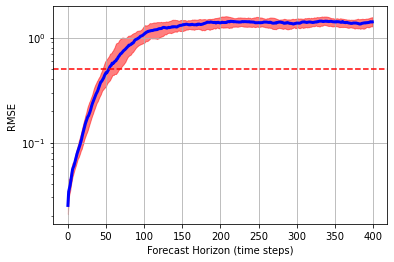

It takes around t = 13.50 for mean error to exceed 0.5


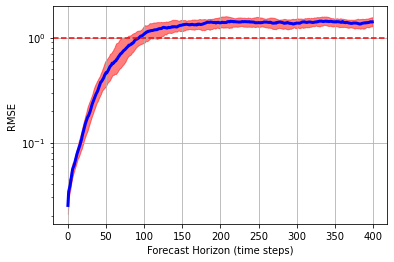

It takes around t = 23.50 for mean error to exceed 1.0

Median NRMSE at t = 5: 0.125
Median NRMSE at t = 10: 0.326
Median NRMSE at t = 20: 0.848
Median NRMSE at t = 50: 1.383
Median NRMSE at t = 99: 1.411


In [24]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([5, 10, 20, 50, 99], dt = .25)

### 3.1.2 nn_size = 6000

In [25]:
nn_size = 6000
lr_list = [5e-4]
epoch_list = [400]

In [26]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 5.03s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 0.51s
W and W_in generated. Time taken: 6.51s

Generating z values...
z values generated. Time taken: 30.15s
Concatenating z with z**2 Contenation complete. Time taken: 6.57s

Epoch 10: Train time = 4.96 | Train Loss = 0.0001242 
Epoch 20: Train time = 8.53 | Train Loss = 0.0000769 
Epoch 30: Train time = 6.53 | Train Loss = 0.0000575 
Epoch 40: Train time = 5.56 | Train Loss = 0.0000466 
Epoch 50: Train time = 6.43 | Train Loss = 0.0000415 
Epoch 51: Train time = 6.39 | Train Loss = 0.0000402 
Epoch 52: Train time = 5.99 | Train Loss = 0.0000401 
Epoch 53: Train time = 6.26 | Train Loss = 0.0000390 
Epoch 55: Train time = 6.14 | Train Loss = 0.0000378 
Epoch 57: Train time = 6.58 | Train Loss = 0.0000375 
Epoch 58: Train time = 6.43 | Train Loss = 0.0000368 
Epoch 60: Train time = 6.78 | Train Loss = 0.0000369 
Epoch 61: Train time = 6.15 | Train Loss = 0.0000364 
Epoch 62: Train time = 6.15 | Tra

In [27]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 280.17


In [28]:
save_obj(mean_pred, "results/rc", "3_1_2_mu_preds.pkl")

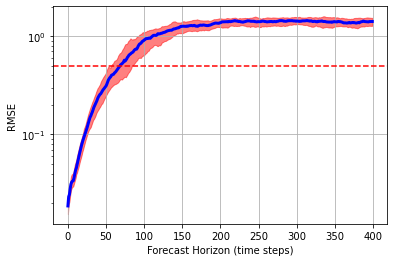

It takes around t = 17.25 for mean error to exceed 0.5


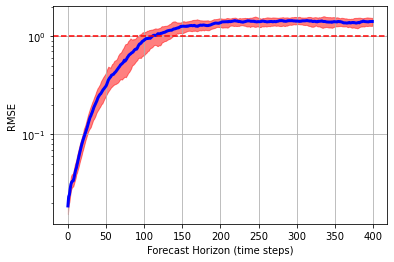

It takes around t = 27.75 for mean error to exceed 1.0

Median NRMSE at t = 5: 0.089
Median NRMSE at t = 10: 0.241
Median NRMSE at t = 20: 0.641
Median NRMSE at t = 50: 1.372
Median NRMSE at t = 99: 1.412


In [29]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([5, 10, 20, 50, 99], dt = .25)

### 3.1.3 nn_size = 9000

In [30]:
nn_size = 9000
lr_list = [3e-4]
epoch_list = [400]

In [31]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 12.29s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 0.85s
W and W_in generated. Time taken: 14.99s

Generating z values...
z values generated. Time taken: 45.10s
Concatenating z with z**2 Contenation complete. Time taken: 147.28s

Epoch 10: Train time = 10.64 | Train Loss = 0.0001221 
Epoch 20: Train time = 9.67 | Train Loss = 0.0000715 
Epoch 30: Train time = 11.75 | Train Loss = 0.0000518 
Epoch 40: Train time = 11.40 | Train Loss = 0.0000420 
Epoch 50: Train time = 10.62 | Train Loss = 0.0000351 
Epoch 52: Train time = 11.60 | Train Loss = 0.0000347 
Epoch 53: Train time = 9.95 | Train Loss = 0.0000344 
Epoch 54: Train time = 11.59 | Train Loss = 0.0000338 
Epoch 55: Train time = 10.20 | Train Loss = 0.0000329 
Epoch 57: Train time = 8.98 | Train Loss = 0.0000328 
Epoch 58: Train time = 10.26 | Train Loss = 0.0000324 
Epoch 59: Train time = 10.88 | Train Loss = 0.0000316 
Epoch 60: Train time = 11.24 | Train Loss = 0.0000318 
Epoch 62: Train tim

In [32]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 407.54


In [33]:
save_obj(mean_pred, "results/rc", "3_1_3_mu_preds.pkl")

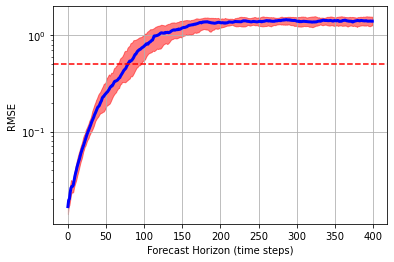

It takes around t = 19.75 for mean error to exceed 0.5


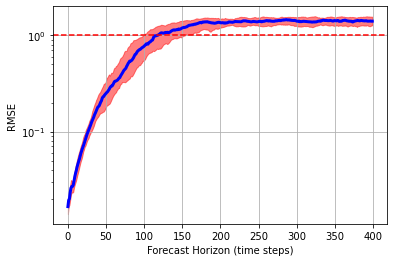

It takes around t = 29.50 for mean error to exceed 1.0

Median NRMSE at t = 5: 0.070
Median NRMSE at t = 10: 0.181
Median NRMSE at t = 20: 0.522
Median NRMSE at t = 50: 1.346
Median NRMSE at t = 99: 1.400


In [34]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([5, 10, 20, 50, 99], dt = .25)

### 3.1.4 nn_size = 12000

In [35]:
nn_size = 12000
lr_list = [1e-4]
epoch_list = [400]

In [36]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 20.66s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 2.21s
W and W_in generated. Time taken: 26.27s

Generating z values...
z values generated. Time taken: 66.10s
Concatenating z with z**2 Contenation complete. Time taken: 270.40s

Epoch 10: Train time = 10.60 | Train Loss = 0.0001927 
Epoch 20: Train time = 10.53 | Train Loss = 0.0000850 
Epoch 30: Train time = 10.50 | Train Loss = 0.0000577 
Epoch 40: Train time = 10.63 | Train Loss = 0.0000441 
Epoch 50: Train time = 10.95 | Train Loss = 0.0000358 
Epoch 51: Train time = 10.39 | Train Loss = 0.0000352 
Epoch 52: Train time = 10.45 | Train Loss = 0.0000344 
Epoch 53: Train time = 11.11 | Train Loss = 0.0000338 
Epoch 54: Train time = 10.63 | Train Loss = 0.0000333 
Epoch 55: Train time = 10.46 | Train Loss = 0.0000327 
Epoch 56: Train time = 10.76 | Train Loss = 0.0000322 
Epoch 57: Train time = 10.96 | Train Loss = 0.0000315 
Epoch 58: Train time = 10.43 | Train Loss = 0.0000314 
Epoch 59: Train 

In [37]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 486.09


In [38]:
save_obj(mean_pred, "results/rc", "3_1_4_mu_preds.pkl")

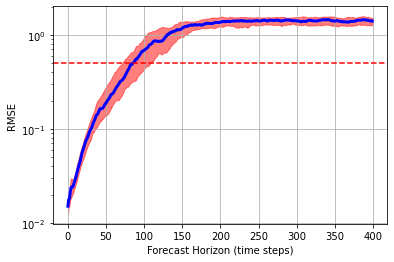

It takes around t = 21.50 for mean error to exceed 0.5


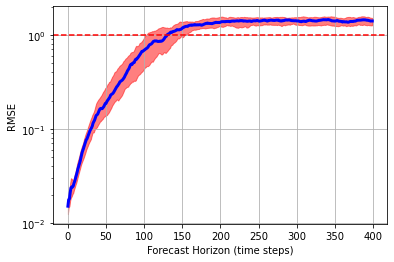

It takes around t = 32.75 for mean error to exceed 1.0

Median NRMSE at t = 5: 0.060
Median NRMSE at t = 10: 0.150
Median NRMSE at t = 20: 0.438
Median NRMSE at t = 50: 1.365
Median NRMSE at t = 99: 1.408


In [39]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([5, 10, 20, 50, 99], dt = .25)

### 3.1.5 nn_size = 15000

In [40]:
nn_size = 15000
lr_list = [1e-4]
epoch_list = [400]

In [41]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 29.95s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 2.68s
W and W_in generated. Time taken: 37.29s

Generating z values...
z values generated. Time taken: 75.46s
Concatenating z with z**2 Contenation complete. Time taken: 30.65s

Epoch 10: Train time = 13.05 | Train Loss = 0.0001613 
Epoch 20: Train time = 12.92 | Train Loss = 0.0000757 
Epoch 30: Train time = 13.09 | Train Loss = 0.0000521 
Epoch 40: Train time = 13.02 | Train Loss = 0.0000399 
Epoch 50: Train time = 13.06 | Train Loss = 0.0000325 
Epoch 51: Train time = 13.03 | Train Loss = 0.0000318 
Epoch 52: Train time = 12.97 | Train Loss = 0.0000314 
Epoch 53: Train time = 13.12 | Train Loss = 0.0000308 
Epoch 54: Train time = 13.03 | Train Loss = 0.0000302 
Epoch 55: Train time = 12.91 | Train Loss = 0.0000298 
Epoch 56: Train time = 13.04 | Train Loss = 0.0000293 
Epoch 57: Train time = 12.99 | Train Loss = 0.0000291 
Epoch 58: Train time = 12.88 | Train Loss = 0.0000282 
Epoch 59: Train t

In [42]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 719.38


In [43]:
save_obj(mean_pred, "results/rc", "3_1_5_mu_preds.pkl")

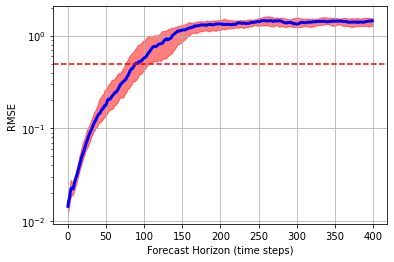

It takes around t = 22.50 for mean error to exceed 0.5


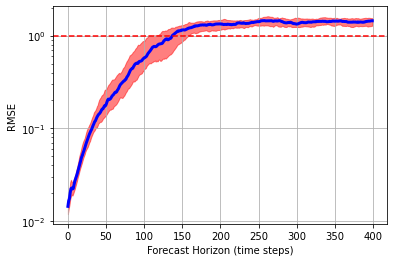

It takes around t = 34.25 for mean error to exceed 1.0

Median NRMSE at t = 5: 0.054
Median NRMSE at t = 10: 0.141
Median NRMSE at t = 20: 0.391
Median NRMSE at t = 50: 1.338
Median NRMSE at t = 99: 1.435


In [44]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([5, 10, 20, 50, 99], dt = .25)

## 3.2 lambda (ridge penalty)

**Parameters**
- nn_size = 15000
- connectivity = 4
- spec_radius = 0.5
- lambda = [1e-2, 1e-4, 1e-6]

In [15]:
nn_size = 15000
lr_list = [1e-4]
epoch_list = [400]

### 3.2.1 lambda = 1e-2

In [46]:
ridge_penalty = 1e-2

In [47]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 29.44s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 1.83s
W and W_in generated. Time taken: 36.04s

Generating z values...
z values generated. Time taken: 98.09s
Concatenating z with z**2 Contenation complete. Time taken: 15.54s

Epoch 10: Train time = 14.29 | Train Loss = 0.0001616 
Epoch 20: Train time = 16.05 | Train Loss = 0.0000760 
Epoch 30: Train time = 15.89 | Train Loss = 0.0000524 
Epoch 40: Train time = 15.95 | Train Loss = 0.0000402 
Epoch 50: Train time = 16.08 | Train Loss = 0.0000329 
Epoch 51: Train time = 15.93 | Train Loss = 0.0000322 
Epoch 52: Train time = 15.97 | Train Loss = 0.0000318 
Epoch 53: Train time = 15.98 | Train Loss = 0.0000312 
Epoch 54: Train time = 16.05 | Train Loss = 0.0000306 
Epoch 55: Train time = 16.10 | Train Loss = 0.0000302 
Epoch 56: Train time = 15.86 | Train Loss = 0.0000297 
Epoch 57: Train time = 15.91 | Train Loss = 0.0000295 
Epoch 58: Train time = 15.95 | Train Loss = 0.0000286 
Epoch 59: Train t

In [48]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 682.20


In [49]:
save_obj(mean_pred, "results/rc", "3_2_1_mu_preds.pkl")

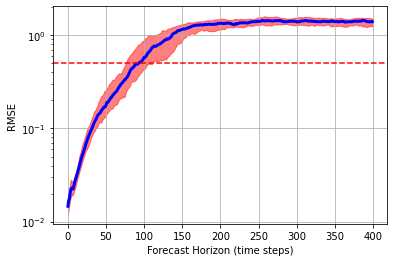

It takes around t = 23.25 for mean error to exceed 0.5


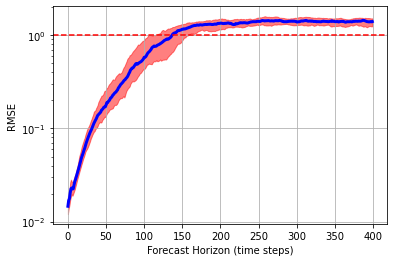

It takes around t = 34.25 for mean error to exceed 1.0

Median NRMSE at t = 5: 0.055
Median NRMSE at t = 10: 0.140
Median NRMSE at t = 20: 0.388
Median NRMSE at t = 50: 1.342
Median NRMSE at t = 99: 1.393


In [50]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([5, 10, 20, 50, 99], dt = .25)

### 3.2.2 lambda = 1e-4
Already done in section 3.1.5

### 3.2.3 lambda = 1e-6

In [16]:
ridge_penalty = 1e-6

In [17]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 33.61s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 2.43s
W and W_in generated. Time taken: 40.80s

Generating z values...
z values generated. Time taken: 83.21s
Concatenating z with z**2 Contenation complete. Time taken: 14.76s

Epoch 10: Train time = 12.79 | Train Loss = 0.0001613 
Epoch 20: Train time = 12.27 | Train Loss = 0.0000757 
Epoch 30: Train time = 12.47 | Train Loss = 0.0000520 
Epoch 40: Train time = 12.75 | Train Loss = 0.0000399 
Epoch 50: Train time = 12.66 | Train Loss = 0.0000325 
Epoch 51: Train time = 13.60 | Train Loss = 0.0000319 
Epoch 52: Train time = 12.68 | Train Loss = 0.0000314 
Epoch 53: Train time = 12.65 | Train Loss = 0.0000308 
Epoch 54: Train time = 12.66 | Train Loss = 0.0000302 
Epoch 55: Train time = 12.81 | Train Loss = 0.0000298 
Epoch 56: Train time = 12.63 | Train Loss = 0.0000293 
Epoch 57: Train time = 12.61 | Train Loss = 0.0000291 
Epoch 58: Train time = 12.66 | Train Loss = 0.0000282 
Epoch 59: Train t

In [18]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 675.18


In [19]:
save_obj(mean_pred, "results/rc", "3_2_3_mu_preds.pkl")

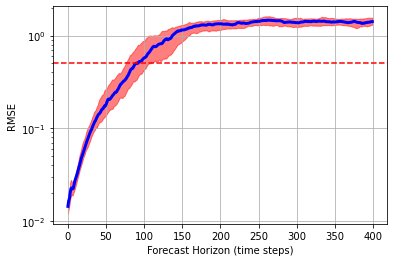

It takes around t = 22.50 for mean error to exceed 0.5


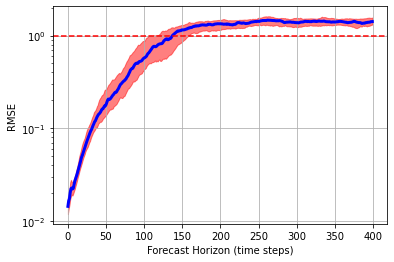

It takes around t = 34.50 for mean error to exceed 1.0

Median NRMSE at t = 5: 0.054
Median NRMSE at t = 10: 0.141
Median NRMSE at t = 20: 0.390
Median NRMSE at t = 50: 1.342
Median NRMSE at t = 99: 1.395


In [20]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([5, 10, 20, 50, 99], dt = .25)

## 3.3 spec_radius

**Parameters**
- nn_size = 15000
- connectivity = 4
- spec_radius = [0.1, 0.3, 0.5, 0.7]
- lambda = 1e-6

In [12]:
nn_size = 15000
lr_list = [1e-4]
epoch_list = [400]
ridge_peanlty = 1e-2

### 3.3.1 spec_radius = 0.1

In [22]:
spec_radius = 0.1

In [23]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 33.01s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 2.92s
W and W_in generated. Time taken: 40.77s

Generating z values...
z values generated. Time taken: 95.61s
Concatenating z with z**2 Contenation complete. Time taken: 14.74s

Epoch 10: Train time = 14.35 | Train Loss = 0.0002154 
Epoch 20: Train time = 13.83 | Train Loss = 0.0000983 
Epoch 30: Train time = 13.86 | Train Loss = 0.0000664 
Epoch 40: Train time = 14.40 | Train Loss = 0.0000519 
Epoch 50: Train time = 14.49 | Train Loss = 0.0000440 
Epoch 51: Train time = 14.40 | Train Loss = 0.0000430 
Epoch 52: Train time = 14.48 | Train Loss = 0.0000426 
Epoch 53: Train time = 14.37 | Train Loss = 0.0000420 
Epoch 54: Train time = 14.60 | Train Loss = 0.0000414 
Epoch 55: Train time = 14.34 | Train Loss = 0.0000410 
Epoch 56: Train time = 14.52 | Train Loss = 0.0000403 
Epoch 57: Train time = 14.58 | Train Loss = 0.0000398 
Epoch 58: Train time = 14.49 | Train Loss = 0.0000392 
Epoch 59: Train t

In [24]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 678.12


In [25]:
save_obj(mean_pred, "results/rc", "3_3_1_mu_preds.pkl")

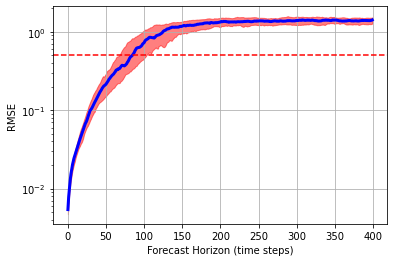

It takes around t = 21.25 for mean error to exceed 0.5


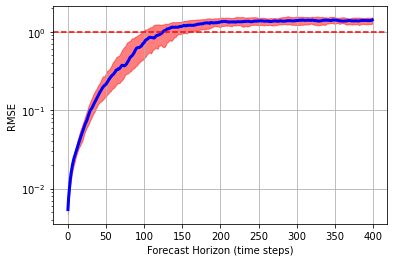

It takes around t = 31.25 for mean error to exceed 1.0

Median NRMSE at t = 5: 0.056
Median NRMSE at t = 10: 0.156
Median NRMSE at t = 20: 0.443
Median NRMSE at t = 50: 1.338
Median NRMSE at t = 99: 1.393


In [26]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([5, 10, 20, 50, 99], dt = .25)

### 3.3.2 spec_radius = 0.3

In [27]:
spec_radius = 0.3

In [28]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 37.99s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 6.43s
W and W_in generated. Time taken: 49.66s

Generating z values...
z values generated. Time taken: 164.98s
Concatenating z with z**2 Contenation complete. Time taken: 15.72s

Epoch 10: Train time = 13.04 | Train Loss = 0.0001885 
Epoch 20: Train time = 13.65 | Train Loss = 0.0000786 
Epoch 30: Train time = 13.76 | Train Loss = 0.0000529 
Epoch 40: Train time = 13.75 | Train Loss = 0.0000420 
Epoch 50: Train time = 13.75 | Train Loss = 0.0000360 
Epoch 51: Train time = 13.70 | Train Loss = 0.0000354 
Epoch 52: Train time = 14.15 | Train Loss = 0.0000349 
Epoch 53: Train time = 14.26 | Train Loss = 0.0000345 
Epoch 54: Train time = 14.13 | Train Loss = 0.0000340 
Epoch 55: Train time = 14.24 | Train Loss = 0.0000337 
Epoch 56: Train time = 14.16 | Train Loss = 0.0000333 
Epoch 57: Train time = 14.10 | Train Loss = 0.0000328 
Epoch 58: Train time = 14.21 | Train Loss = 0.0000323 
Epoch 59: Train 

In [29]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 615.86


In [30]:
save_obj(mean_pred, "results/rc", "3_3_2_mu_preds.pkl")

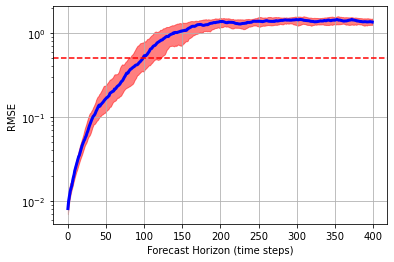

It takes around t = 24.75 for mean error to exceed 0.5


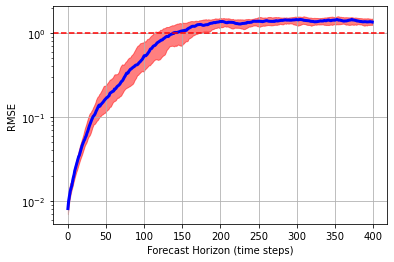

It takes around t = 34.50 for mean error to exceed 1.0

Median NRMSE at t = 5: 0.049
Median NRMSE at t = 10: 0.135
Median NRMSE at t = 20: 0.351
Median NRMSE at t = 50: 1.373
Median NRMSE at t = 99: 1.367


In [31]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([5, 10, 20, 50, 99], dt = .25)

### 3.3.3 spec_radius = 0.5
Already done in 3.2.1

### 3.3.4 spec_radius = 0.7

In [13]:
spec_radius = 0.7

In [14]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 33.45s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 2.47s
W and W_in generated. Time taken: 40.66s

Generating z values...
z values generated. Time taken: 100.05s
Concatenating z with z**2 Contenation complete. Time taken: 18.07s

Epoch 10: Train time = 13.66 | Train Loss = 0.0001974 
Epoch 20: Train time = 13.75 | Train Loss = 0.0000816 
Epoch 30: Train time = 14.02 | Train Loss = 0.0000524 
Epoch 40: Train time = 13.84 | Train Loss = 0.0000397 
Epoch 50: Train time = 13.90 | Train Loss = 0.0000324 
Epoch 51: Train time = 14.14 | Train Loss = 0.0000321 
Epoch 52: Train time = 13.76 | Train Loss = 0.0000314 
Epoch 53: Train time = 13.91 | Train Loss = 0.0000307 
Epoch 54: Train time = 13.98 | Train Loss = 0.0000304 
Epoch 55: Train time = 13.72 | Train Loss = 0.0000299 
Epoch 56: Train time = 13.89 | Train Loss = 0.0000293 
Epoch 57: Train time = 13.85 | Train Loss = 0.0000290 
Epoch 58: Train time = 13.99 | Train Loss = 0.0000286 
Epoch 59: Train 

In [15]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 660.41


In [16]:
save_obj(mean_pred, "results/rc", "3_3_4_mu_preds.pkl")

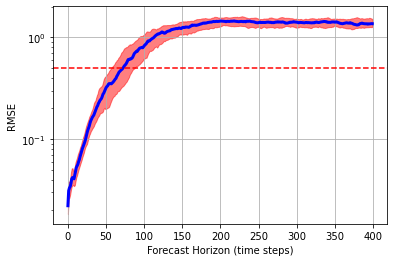

It takes around t = 18.25 for mean error to exceed 0.5


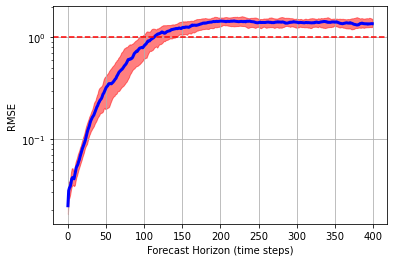

It takes around t = 28.25 for mean error to exceed 1.0

Median NRMSE at t = 5: 0.084
Median NRMSE at t = 10: 0.224
Median NRMSE at t = 20: 0.606
Median NRMSE at t = 50: 1.443
Median NRMSE at t = 99: 1.356


In [17]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([5, 10, 20, 50, 99], dt = .25)

## 3.4 connectivity

**Parameters**
- nn_size = 15000
- connectivity = [4, 8]
- spec_radius = 0.3
- lambda = 1e-2

In [25]:
nn_size = 15000
ridge_peanlty = 1e-2
spec_radius = 0.3

lr_list = [1e-4]
epoch_list = [400]

### 3.4.1 connectivity = 4 
Already done in Section 3.3.2

### 3.4.2 connectivity = 8

In [14]:
connectivity = 8

In [15]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 40.79s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 2.43s
W and W_in generated. Time taken: 48.21s

Generating z values...
z values generated. Time taken: 108.17s
Concatenating z with z**2 Contenation complete. Time taken: 14.44s

Epoch 10: Train time = 12.88 | Train Loss = 0.0001910 
Epoch 20: Train time = 12.66 | Train Loss = 0.0000789 
Epoch 30: Train time = 13.42 | Train Loss = 0.0000530 
Epoch 40: Train time = 12.41 | Train Loss = 0.0000421 
Epoch 50: Train time = 12.37 | Train Loss = 0.0000362 
Epoch 51: Train time = 12.44 | Train Loss = 0.0000353 
Epoch 52: Train time = 12.43 | Train Loss = 0.0000349 
Epoch 53: Train time = 12.38 | Train Loss = 0.0000345 
Epoch 54: Train time = 12.39 | Train Loss = 0.0000342 
Epoch 55: Train time = 12.42 | Train Loss = 0.0000334 
Epoch 57: Train time = 12.38 | Train Loss = 0.0000327 
Epoch 58: Train time = 12.38 | Train Loss = 0.0000323 
Epoch 59: Train time = 12.45 | Train Loss = 0.0000322 
Epoch 60: Train 

In [16]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 788.83


In [17]:
save_obj(mean_pred, "results/rc", "3_4_2_mu_preds.pkl")

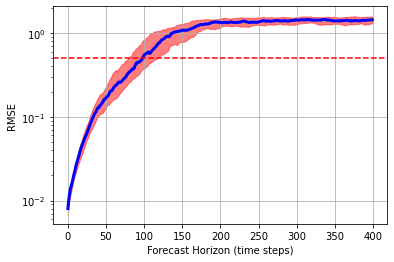

It takes around t = 24.50 for mean error to exceed 0.5


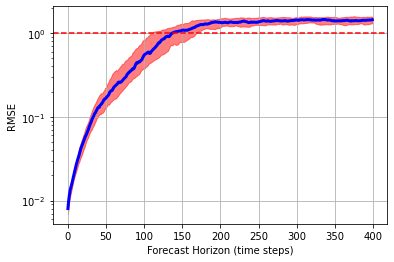

It takes around t = 34.50 for mean error to exceed 1.0

Median NRMSE at t = 5: 0.050
Median NRMSE at t = 10: 0.130
Median NRMSE at t = 20: 0.340
Median NRMSE at t = 50: 1.335
Median NRMSE at t = 99: 1.428


In [18]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([5, 10, 20, 50, 99], dt = .25)

# 4. Best model
nn_size = 12000  
beta = 1e-6  
connectivity = 4  
spec_radius = 0.1

In [19]:
nn_size = 15000
ridge_peanlty = 1e-2
spec_radius = 0.3
connectivity = 4

lr_list = [1e-4]
epoch_list = [600]

transient = 200  # points to ignore to allow system to stabilise
omega = 1         # scale of the values of matrix W
alpha = 1         # hidden state memory
b_size = 200

In [20]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 38.59s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 2.29s
W and W_in generated. Time taken: 46.52s

Generating z values...
z values generated. Time taken: 101.59s
Concatenating z with z**2 Contenation complete. Time taken: 17.46s

Epoch 10: Train time = 17.34 | Train Loss = 0.0001887 
Epoch 20: Train time = 16.83 | Train Loss = 0.0000787 
Epoch 30: Train time = 15.52 | Train Loss = 0.0000530 
Epoch 40: Train time = 14.53 | Train Loss = 0.0000420 
Epoch 50: Train time = 16.29 | Train Loss = 0.0000360 
Epoch 51: Train time = 16.48 | Train Loss = 0.0000354 
Epoch 52: Train time = 16.45 | Train Loss = 0.0000349 
Epoch 53: Train time = 16.25 | Train Loss = 0.0000345 
Epoch 54: Train time = 16.28 | Train Loss = 0.0000340 
Epoch 55: Train time = 16.41 | Train Loss = 0.0000337 
Epoch 56: Train time = 16.64 | Train Loss = 0.0000333 
Epoch 57: Train time = 16.32 | Train Loss = 0.0000328 
Epoch 58: Train time = 16.30 | Train Loss = 0.0000323 
Epoch 59: Train 

In [21]:
save_obj(mean_pred, "results/rc", "best_mu_preds.pkl")
save_obj(W, "results/rc", "best_W.pkl")
save_obj(W_in, "results/rc", "best_W_in.pkl")
save_obj(params, "results/rc", "best_params.pkl")

In [22]:
# W = load_obj("results/rc/best_W.pkl")
# W_in = load_obj("results/rc/best_W_in.pkl")
# params = load_obj("results/rc/best_params.pkl")

In [23]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 672.32


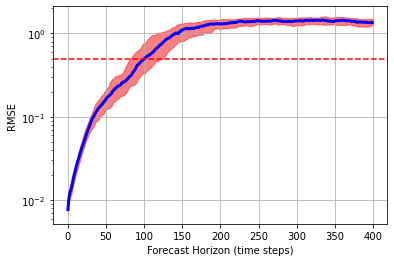

It takes around t = 25.25 for mean error to exceed 0.5


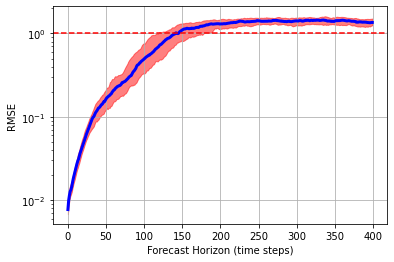

It takes around t = 35.25 for mean error to exceed 1.0

Median NRMSE at t = 5: 0.047
Median NRMSE at t = 10: 0.127
Median NRMSE at t = 20: 0.299
Median NRMSE at t = 50: 1.298
Median NRMSE at t = 99: 1.344


In [26]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5, dt = .25)
res_single.plot_rmse(error_thresh = 1., dt = .25)
print()
res_single.get_loss([5, 10, 20, 50, 99], dt = .25)

**check disk space**

In [ ]:
def get_size(start_path = '.'):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)

    return total_size

print(get_size("results/rc") / (2**30), 'GiB')

0.48419769294559956 GiB


In [ ]:
import shutil

total, used, free = shutil.disk_usage("/")

print("Total: %d GiB" % (total // (2**30)))
print("Used: %d GiB" % (used // (2**30)))
print("Free: %d GiB" % (free // (2**30)))

Total: 192 GiB
Used: 181 GiB
Free: 0 GiB


# 5. Plot images based on Lyapunov Time

In [11]:
mean_pred = load_obj("results/rc/best_mu_preds.pkl")

In [15]:
save_obj(mean_pred, "results", "rc_pred.pkl")

In [16]:
total_lyapunov_time_pred = 100 / KS_LT # Amount of Lyapunov Time in Test set

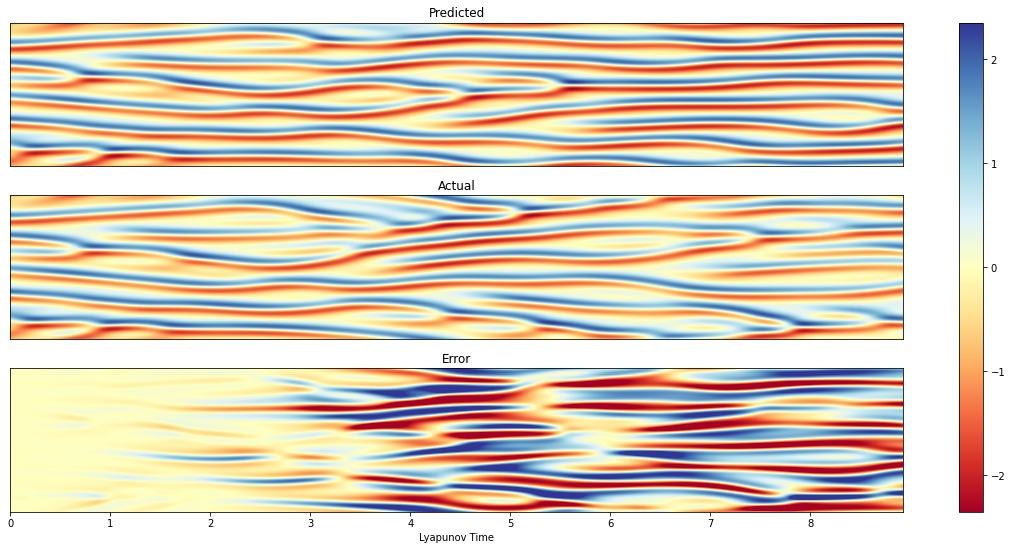

In [17]:
plot_predictions(mean_pred, y_test, total_lyapunov_time_pred, save_name = "Figure3-5b_RC_Prediction_Diagram")

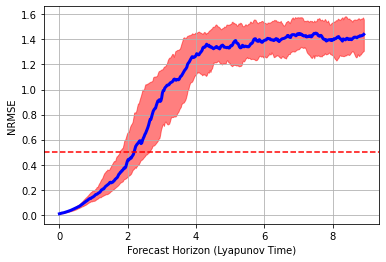

It takes around 2.19 Lyapunov Time for mean error to exceed 0.5

Median NRMSE at 0.5 Lyapunov Time: 0.055
Median NRMSE at 1.0 Lyapunov Time: 0.142
Median NRMSE at 2.0 Lyapunov Time: 0.427
Median NRMSE at 5.0 Lyapunov Time: 1.345


In [18]:
res_single = PointExperimentResultLyapunov(mean_pred - y_test, "ks")
res_single.plot_rmse(save_name = "Figure3-6b_RC_Prediction_Horizon")
print()
res_single.get_loss()